# Loading/Testing CM2.6 data + naive air sea flux attempt


## Notes
- The regridding will crash for the global dataset. Trying a subset now
- We have a grid file for the ocean, but not the atmosphere? confirm that this is regular lon/lat grid


![image.png](attachment:436b19d1-c606-443e-8e68-d1753a2b1d3f.png)

rho = density of moist air

C_H = exchange coefficient for sensible heat

C_P = heat capacity of moist air


In [1]:
import xarray as xr
import intake
import xesmf as xe
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
# load the ocean data
kwargs = dict(consolidated=True, use_cftime=True)
ds_flux = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/ocean_boundary', **kwargs)
ds = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/surface', **kwargs)
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_grid  = xr.open_zarr('gs://cmip6/GFDL_CM2_6/grid', **kwargs)

# cut to same size
ds_atmos = ds_atmos.sel(time=slice('0181', '0201'))

In [3]:
# convert SST to K (🚨 a job for pint-xarray)
ds['surface_temp'] = ds.surface_temp + 273.15

## Interpolate atmos onto ocean

In [15]:
# Build the weights (fails on the cloud)
regridder = xe.Regridder(ds_atmos, ds.surface_temp, 'bilinear', periodic=True, filename='CM26_atmos2ocean_weights.nc') # all the atmos data is on the cell center AFAIK

# # reuse the weightfile
# regridder = xe.Regridder(ds_atmos, ds.surface_temp, 'bilinear', periodic=True, weights='CM26_atmos2ocean_weights.nc', reuse_weights=True) # all the atmos data is on the cell center AFAIK

/home/julius/.conda/envs/new_base/envs/scale-aware-air-sea/lib/python3.10/site-packages/dask/array/core.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [16]:
with ProgressBar():
    for var in ['wind', 't_ref', 'q_ref', 'ps']:
        ds[var] = regridder(ds_atmos[var])

In [17]:
## hopelessly naive approach

# constant density
rho = 1 # order of magnitude [kg/m3]

# Heat capacity
C_P = 1e3 # order of magnitude [J/kg/C]

# Exchange coefficient
C_Hs = 1e-3

In [18]:
hflux_sens_naive = rho * C_P * C_Hs * ds.wind * (ds.t_ref - ds.surface_temp)
hflux_sens_naive = hflux_sens_naive.resample(time='1MS').mean()
hflux_sens_naive

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<stack, shape=(240, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 00:00:00 ... 0200-12-01 00:00:00
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

Text(0.5, 1.0, 'difference [%]')

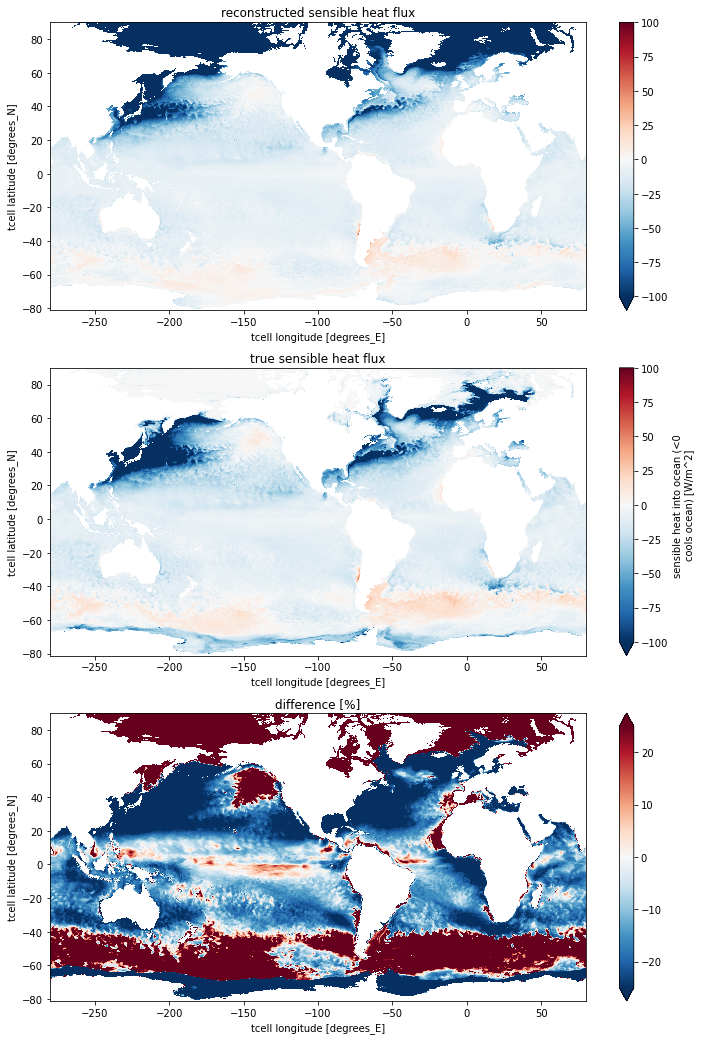

In [19]:
reconstructed = hflux_sens_naive.isel(time=0)
truth = ds_flux.sens_heat.isel(time=0)

plt.figure(figsize=[12,18])

plt.subplot(3,1,1)
reconstructed.plot(vmax=100, center=0)
plt.title('reconstructed sensible heat flux')

plt.subplot(3,1,2)
truth.plot(vmax=100, center=0)
plt.title('true sensible heat flux')

plt.subplot(3,1,3)
((truth-reconstructed)/abs(truth)*100).plot(vmax=25)
plt.title('difference [%]')

### Test regridding (fail example)

Seems to succeed on gyre! Interesting...

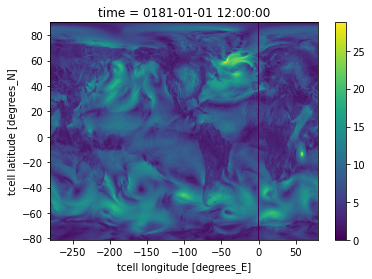

In [9]:
sample = ds_atmos.wind.isel(time=0)
    
# This does never run
regridder(sample).load().plot()

# # # This runs without problems
# regridder(sample.load()).plot()